# Analyze HBC Savings

In [1]:
import pandas as pd
import seaborn as sns
INPUT_JSONL = '/mnt/ceph/storage/data-in-progress/data-research/web-search/private-web-search-with-keyqueries/scrambling-on-anserini/hbc-query-savings-overview.jsonl'

df = pd.read_json(INPUT_JSONL, lines=True)
df

,submittedQueries,exhaustiveSearchNumberOfQueries,topic,method
0,149,385,128,bm25
1,381,385,2,bm25
2,649,255,131,bm25
3,981,56,262,bm25
4,516,255,8,bm25
...,...,...,...,...
119,385,385,119,qld
120,385,385,121,qld
121,261,385,123,qld
122,344,385,253,qld


In [3]:
len(df[df['exhaustiveSearchNumberOfQueries'] < df['submittedQueries']])

24

In [7]:
len(df[df['exhaustiveSearchNumberOfQueries'] != 385])

29

In [4]:
df['saved'] = 1- (df['submittedQueries']/df['exhaustiveSearchNumberOfQueries'])

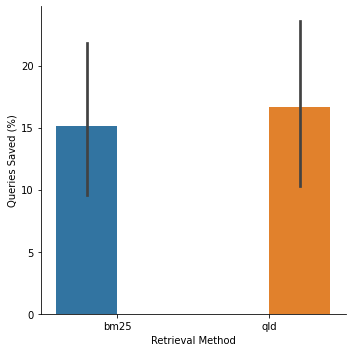

In [19]:
df_plot = df[df['exhaustiveSearchNumberOfQueries'] >= df['submittedQueries']].copy()
df_plot['Retrieval Method'] = df_plot['method'].astype(str)
df_plot['Queries Saved (%)'] = df_plot['saved']*100

g = sns.catplot(data=df_plot, x='Retrieval Method', y='Queries Saved (%)', hue='Retrieval Method', kind='bar', ci=95)

In [20]:
g.savefig('hbc-saved-queries.pdf')

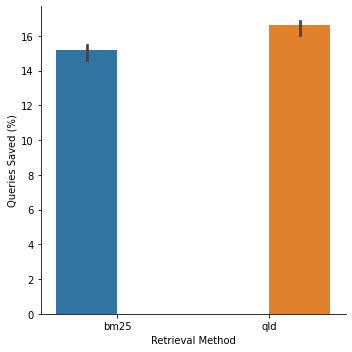

In [16]:
df_plot = df[df['exhaustiveSearchNumberOfQueries'] >= df['submittedQueries']].copy()
df_plot['Retrieval Method'] = df_plot['method'].astype(str)
df_plot['Queries Saved (%)'] = df_plot['saved']*100

sns.catplot(data=df_plot, x='Retrieval Method', y='Queries Saved (%)', hue='Retrieval Method', kind='bar', ci=10)

# Calculate HBC Savings for other Scrambling Approaches:



In [22]:
DATA_DIR = '/mnt/ceph/storage/data-in-progress/data-research/web-search/private-web-search-with-keyqueries/'
QUERY_DIR = DATA_DIR + 'scrambling-on-anserini/'

SCRAMBLING_APPROACHES = [('tf-idf', 'HbcTfIdf'), ('arampatzis', 'arampatzisHbc')]
RETRIEVAL_MODELS = ['bm25', 'qld']
TOPICS = [2, 8, 11, 17, 18, 26, 30, 33, 38, 40, 46, 47, 50, 57, 59, 61, 62, 66, 67, 78, 82, 88, 89, 95, 98, 104, 105, 109, 111, 117, 119, 121, 123, 128, 131, 136, 140, 142, 147, 152, 156, 162, 168, 173, 175, 177, 182, 196, 199, 207, 213, 222, 236, 253, 254, 262, 266, 273, 286, 287, 209, 214]

In [24]:
from tqdm import tqdm 
df_new = []

def count_lines_in_file(file_name):
    ret = 0
    with open(file_name) as f:
        for i in f:
            ret += 1
    return ret

for scr in SCRAMBLING_APPROACHES:
    for rtr in RETRIEVAL_MODELS:
        for topic in tqdm(TOPICS):
            hbc_submitted_queries = count_lines_in_file(QUERY_DIR + '/' + scr[1] + '-' + rtr +'/' + str(topic) + '.jsonl')
            exhaustive_submitted_queries = count_lines_in_file(QUERY_DIR + '/' + scr[0] + '-' + rtr +'/' + str(topic) + '.jsonl')
            
            df_new += [{
                'hbc_queries': hbc_submitted_queries,
                'exhaustive_queries': exhaustive_submitted_queries,
                'topic': topic,
                'retrieval_model': rtr,
                'scrambling_method': scr[0],
            }]
            
df_new = pd.DataFrame(df_new)      

100%|██████████| 62/62 [01:34<00:00,  1.53s/it]


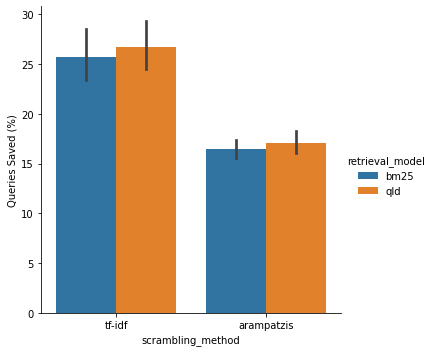

In [29]:
df_new['Queries Saved (%)'] = (1-(df_new['hbc_queries'] / df_new['exhaustive_queries']))*100

sns.catplot(data=df_new, x='scrambling_method', y='Queries Saved (%)', hue='retrieval_model', kind='bar')

In [30]:
df_new['Queries Saved (Total)'] = df_new['exhaustive_queries']-df_new['hbc_queries']

df_new.groupby(['retrieval_model', 'scrambling_method']).mean()['Queries Saved (Total)']

retrieval_model  scrambling_method
bm25             arampatzis           41150.241935
                 tf-idf                 274.032258
qld              arampatzis           51554.419355
                 tf-idf                 277.258065
Name: Queries Saved (Total), dtype: float64